In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import *
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import *
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_uci, linearly_sep2D, noisify, NoisyEstimator, AdaBoost

import warnings
warnings.filterwarnings('ignore')

### Impact of Label Noise on Decision Boundary of LinearSVC

In [2]:
def plot_contour(clf,y): #TRAINED CLASSIFIER
    xx,yy = np.meshgrid(np.arange(0,1,.01),np.arange(0,1,.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx,yy,Z,alpha=.5,colors='red');
    plt.scatter(X[:,0],X[:,1],c=y);
    
def plot_line(clf,v,lab):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(0, 1)
    yy = a * xx - (clf.intercept_[0]) / w[1]
    plt.xlim(-.05,1.05);plt.ylim(-.05,1.05)
    plt.plot(xx, yy, v,label=lab)


In [3]:
X,y = linearly_sep2D(n_samples=400,dist=.10,random_state=42)
yn = noisify(y,.3,random_state=42)

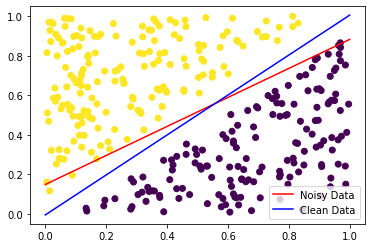

In [4]:
clf = LinearSVC(C=100.0,max_iter=2000,random_state=42)
plot_line(clf.fit(X,yn),'r-','Noisy Data')
plot_line(clf.fit(X,y),'b-','Clean Data')
plt.scatter(X[:,0],X[:,1],c=y);
plt.legend()
plt.savefig("figures/orig.png",format='png')

### Impact of Label Noise on Different Classifiers

In [5]:
DATASETS = ['iris','breast','wine','vowel','segment','spambase','optdigits']
cv = RepeatedStratifiedKFold(n_repeats=3,n_splits=5,random_state=42)
models = {
    'DT': DecisionTreeClassifier(),
    'NB': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'LR': LogisticRegression(),
    'RF': RandomForestClassifier(n_estimators=100,n_jobs=1),
    'Extra': ExtraTreesClassifier(n_estimators=100,n_jobs=1),
    'SVM': LinearSVC(),
    'XGB': XGBClassifier(),
    'LGB': LGBMClassifier(),
}

In [6]:
%%time
def compute(file):
    df = pd.DataFrame(index=DATASETS)
    for d in DATASETS:
        X,y = read_uci(d,True)
        for name,clf in models.items():
            if "Noisy" in file:
                clf = NoisyEstimator(clf,.20)
            clf = make_pipeline(StandardScaler(),clf)
            r = cross_val_score(clf,X,y,cv=cv,n_jobs=5).mean()
            df.loc[d,name] = r
            print(name,r)
        print()
    df.to_csv(file)

compute("results/Clean.csv")
print("Clean Computation complete\n")
compute("results/Noisy20.csv")

iris (150, 4) 3 1.0 [50 50 50]
DT 0.9422222222222223
NB 0.9555555555555556
KNN 0.9555555555555556
LR 0.9555555555555556
RF 0.9533333333333334
Extra 0.948888888888889
SVM 0.928888888888889
XGB 0.948888888888889
LGB 0.9600000000000001

breast (569, 30) 2 0.5938375350140056 [212 357]
DT 0.9174093049733478
NB 0.9332453552760959
KNN 0.9666356155876416
LR 0.9759716400144905
RF 0.9578067587848678
Extra 0.9660094188273044
SVM 0.9666097396884543
XGB 0.9607255602132175
LGB 0.9607255602132176

wine (178, 13) 3 0.676056338028169 [59 71 48]
DT 0.9046560846560845
NB 0.9719047619047618
KNN 0.9588888888888888
LR 0.9795238095238096
RF 0.9831746031746031
Extra 0.9888359788359788
SVM 0.9831746031746033
XGB 0.9662962962962962
LGB 0.97005291005291

vowel (990, 13) 11 1.0 [90 90 90 90 90 90 90 90 90 90 90]
DT 0.8023569023569024
NB 0.6609427609427609
KNN 0.9074074074074073
LR 0.6696969696969697
RF 0.9676767676767677
Extra 0.9845117845117844
SVM 0.5713804713804714
XGB 0.8861952861952862
LGB 0.9265993265993266

In [7]:
clean = pd.read_csv("results/Clean.csv",index_col=0)
noisy = pd.read_csv("results/Noisy20.csv",index_col=0)

In [8]:
clean,noisy = clean.drop(columns='NB'),noisy.drop(columns='NB')

In [9]:
clean = clean.assign(Data='Clean')
noisy = noisy.assign(Data='Noisy')

cmb = pd.concat([pd.melt(clean,id_vars='Data'),pd.melt(noisy,id_vars='Data')],axis=0)
cmb.shape,cmb.columns

((112, 3), Index(['Data', 'variable', 'value'], dtype='object'))

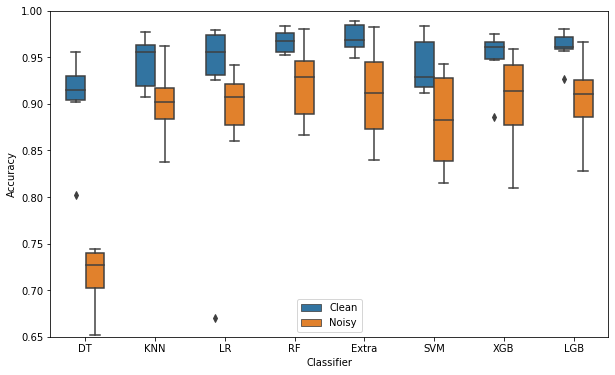

In [10]:
cmb.columns = ['Data', 'Classifier', 'Accuracy']
plt.figure(figsize=(10,6))

plt.ylim(.65,1.0)
ax = sns.boxplot(x='Classifier',y='Accuracy',hue='Data',data=cmb,width=.55);
ax.legend(loc='lower center');
plt.savefig("figures/ClfvsNoise.png");

### Label Noise and Decision Tree

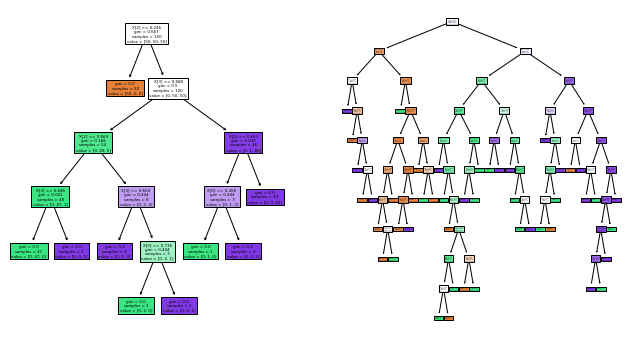

In [11]:
X,y = read_uci('iris')
yn = noisify(y,.2)
plt.figure(figsize=(11,6))
plt.subplot(1,2,1)
plot_tree(DecisionTreeClassifier().fit(X,y),filled=True)

plt.subplot(1,2,2)
plot_tree(DecisionTreeClassifier().fit(X,yn),filled=True)
plt.savefig("figures/DT.png",format='png');
plt.show();

In [12]:
rf = RandomForestClassifier().fit(X,y)
s = [dt.get_n_leaves() for dt in rf.estimators_]
sum(s)/len(s)

8.61

In [13]:
rf = RandomForestClassifier().fit(X,yn)
s = [dt.get_n_leaves() for dt in rf.estimators_]
sum(s)/len(s)

35.23

### Label Noise and Adaboost

In [14]:
X,y = read_uci('breast',True)
yn = noisify(y,.25)
idx = y!=yn
wts = AdaBoost(DecisionTreeClassifier(max_depth=2),20).fit(X,yn).wts
wts[-1][idx].sum(),wts[-1][~idx].sum()

breast (569, 30) 2 0.5938375350140056 [212 357]


(405.273466340281, 163.726533659719)

In [15]:
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation as animation

fig,ax = plt.subplots(figsize=(5,4))
plt.close()
df = pd.DataFrame({'Noisy?':idx})

def draw(wt):
    global ax
    df['Weight'] = wt
    ax.clear()
    ax.set_ylim(0,5.5)
    ax = sns.boxplot(x='Noisy?',y='Weight',data=df,ax=ax,width=.4);
anim = animation.FuncAnimation(fig,draw,wts,interval=600)
anim.save("figures/ada.gif",writer='imagemagick',fps=4)
anim

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


### Impact of regularization

In [16]:
def get_reg_acc(Classifier,param,cv):
    regs = [4,8,16,32,64,128,256]
    res = []
    for s in regs:
        if Classifier==AdaBoost:
            clf = Classifier(base=DecisionTreeClassifier(),T=10)
            clf.set_params(**{param:np.log2(s)})
        else:
            clf = Classifier()
            clf.set_params(**{param:s,'random_state':42})
        clf = NoisyEstimator(clf,.25)
        r = cross_val_score(clf,X,y,cv=cv,n_jobs=4).mean()
        res.append(r.mean())
    return 1 - np.log2(regs),res

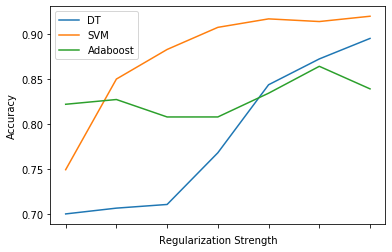

In [17]:
cv = RepeatedStratifiedKFold(n_repeats=3,n_splits=5,random_state=42)

plt.plot(*get_reg_acc(DecisionTreeClassifier,'max_leaf_nodes',cv),label='DT');
plt.plot(*get_reg_acc(LinearSVC,'C',cv),label='SVM');
plt.plot(*get_reg_acc(AdaBoost,'base__max_depth',cv),label='Adaboost');
plt.gca().get_xaxis().set_ticklabels([])
plt.ylabel("Accuracy")
plt.xlabel("Regularization Strength")
plt.legend();
plt.savefig("figures/Reg.png");

### Noise Detection

In [18]:
def ensemble_noise_detect(X,y,thres=.5): #Returns indexes
    rf = RandomForestClassifier(n_estimators=100,oob_score=True).fit(X,y)
    noise_prob = 1 - rf.oob_decision_function_[range(len(X)),y]
    return np.argwhere(noise_prob>thres).reshape(-1)

def kdn_noise_detect(X,y,thres=.5): #Returns indexes
    knn = KNeighborsClassifier(n_neighbors=5).fit(X,y)
    noise_prob = 1 - knn.predict_proba(X)[range(len(X)),y]
    return np.argwhere(noise_prob>thres).reshape(-1)

def calc_TP_FP(data,detector):
    X,y = read_uci(data)
    yn = noisify(y,.25)
    noisy_idx = detector(X,yn,.5)
    actually_noisy = np.argwhere(y!=yn).reshape(-1)
    clean_idx = np.argwhere(y==yn).reshape(-1)
    TP = len(np.intersect1d(noisy_idx,actually_noisy))/len(actually_noisy)
    FP = len(np.intersect1d(noisy_idx,clean_idx))/len(clean_idx)
    return f"TP rate:{TP},FP rate:{FP}"

In [19]:
print("Ensemble of DTs:",calc_TP_FP('spambase',ensemble_noise_detect))
print("Ensemble of DTs:",calc_TP_FP('breast',ensemble_noise_detect))
print("KNN-based:",calc_TP_FP('breast',kdn_noise_detect))

Ensemble of DTs: TP rate:0.8504347826086956,FP rate:0.13619240799768184
Ensemble of DTs: TP rate:0.8943661971830986,FP rate:0.07962529274004684
KNN-based: TP rate:0.6690140845070423,FP rate:0.0585480093676815


### The End